## Multi-Objective Evolution with NSGA-II

To explore NSGA-II, we'll use the [PyMOO](https://pymoo.org/algorithms/moo/nsga2.html) library and a Multi-Objective Travelling Salesman Problem. For the different objectives, we'll construct random distance matrices, but we could imagine, for example, that one objective is travel time between two points and a second objective is travel fuel consumption. We want to minimize both objectives, choosing a route from the Pareto front of quick and low-cost travel.

In [1]:
!pip install pymoo

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

First, we define the Multi-Objective Travelling Salesman Problem using the `ElementwiseProblem` class from `pymoo`. We'll define it to take any number of cities and objectives, returning a fitness of the total from each objective for the given individual. We specify a constraint on the order to ensure we're visiting each city once, but we'll also define the same operators as in the GA notebook to make sure all individuals meet this constraint.

In [3]:
from pymoo.core.problem import ElementwiseProblem

class MOTSP(ElementwiseProblem):

    def __init__(self, n_cities, n_obj):
        # lower bound
        xl = np.zeros(n_cities)
        # upper bound
        xu = (n_cities-1) * np.ones(n_cities)

        self.n_cities = n_cities
        # Each objective is represented as an n_cities x n_cities matrix
        # in which cell [i,j] represents an abstract "cost" (e.g. time or fuel) from i -> j.
        self.objectives = []
        for i in range(n_obj):
            # random symmetric matrix
            obj = np.random.rand(n_cities, n_cities)
            obj = np.tril(obj) + np.tril(obj, -1).T
            obj[np.diag_indices(n_cities)] = 0
            self.objectives.append(obj)

        super().__init__(n_var=n_cities, n_obj=n_obj, n_constr=1,
                        xl=xl, xu=xu)

    def total_cost(self, x, obj):
        cost = 0
        for i in range(1, len(x)):
            cost += self.objectives[obj][x[i-1], x[i]]
        return cost

    def _evaluate(self, x, out, *args, **kwargs):
        # fitness based on each distance matrix
        fits = np.zeros(len(self.objectives))
        for i in range(len(self.objectives)):
            fits[i] = self.total_cost(x, i)

        # check that x conains all cities
        # constraints return negative if met
        c = -np.sum(np.arange(self.n_cities) != np.sort(x))

        # return by modifying out
        out["F"] = np.column_stack(fits)
        out["G"] = np.array([c])

Next, we define NSGA2, its hyperparameters and operators. We'll use the same operators as before. Note that `pymoo` allows for generating fewer offspring than the initial population size and that it can check for duplicates. We'll use this second feature.

In [4]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.erx import EdgeRecombinationCrossover
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.mutation.inversion import InversionMutation

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

To start, let's define a 20-city problem with 2 objectives. As mentioned, these could be total travel time and total travel fuel consumption. We want to minimize both objectives. Note the use of `seed=1` in the call to `minimize`: this optimization is deterministic (we can run it multiple times and get the same result).<br>
See <a href="https://pymoo.org/interface/display.html">pymoo documentation</a> for a description of the printouts.

In [5]:
from pymoo.optimize import minimize

problem = MOTSP(20, 2)
res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      5 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0836683511 |         ideal
     3 |      300 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1599812580 |         ideal
     4 |      400 |      9 |  0.000000E+00 |  0.000000E+00 |  0.1186725895 |         ideal
     5 |      500 |      8 |  0.000000E+00 |  0.000000E+00 |  0.3057338401 |         ideal
     6 |      600 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0464261133 |             f
     7 |      700 |     13 |  0.000000E+00 |  0.000000E+00 |  0.2954540015 |         ideal
     8 |      800 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0363041876 |             f
     9 |      900 |      9 |  0.000000E+00 |  0.000000E+00 |  0.1060807897 |         ideal
    10 |     1000 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0458773437 |             f

The `res` object returned from the search contains the results, including the final Pareto front.

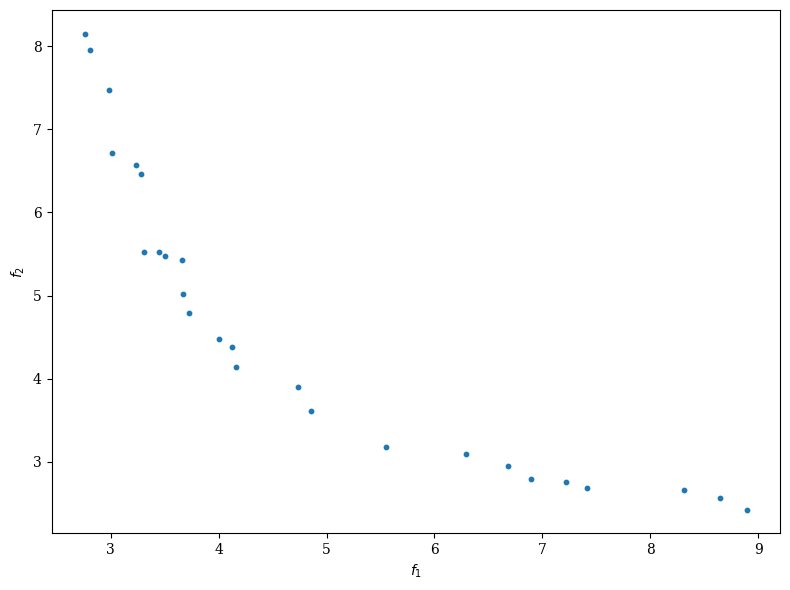

In [6]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(res.F, s=10)
plot.show();

<div class="alert alert-success">
    <h3>Exercise 1</h3>

Look at the [visualization](http://pymoo.org/visualization/index.html) options in pymoo and visualize the population. What plot makes most sense to you to present the full population of possible solutions? What about when the number of objectives increases, ie to 3? What about presenting a single solution?
What is the best performance you can achieve on the 3-objective problem by experimenting with NSGA2 hyperparameters? Please visualize your results.
</div>

## Full population of possible solutions representation

## Scatter plot

<font size=4 color='#d39aed'>
A basic but effective way to represent the full population of possible solutions (2-objective case) is the scatter plot. It clearly shows the distribution and diversity of all individuals across the objectives, and it’s visually easy to identify the Pareto front and its diversity, based on how spread out the points are.
<font>

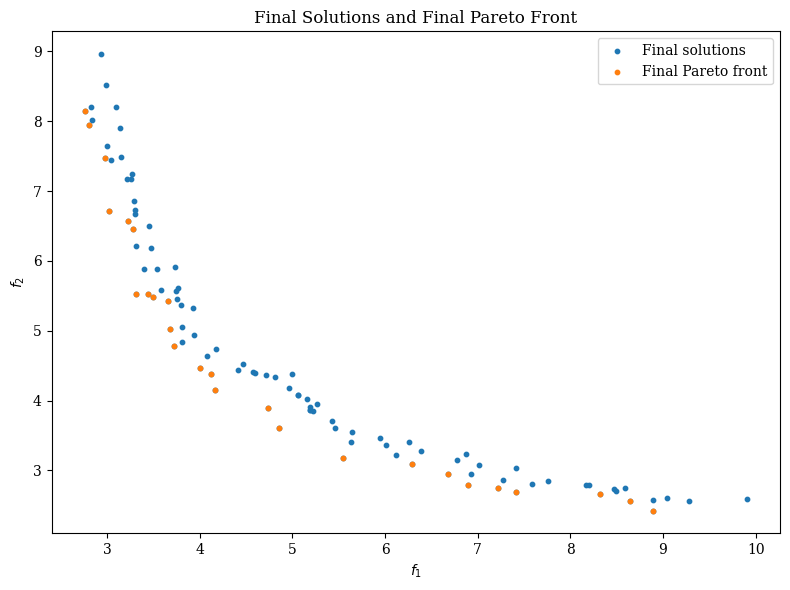

In [7]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(title = "Final Solutions and Final Pareto Front", tight_layout=True)
plot.add(res.algorithm.pop.get("F"), s=10, label = "Final solutions")
plot.add(res.F, s=10, label = "Final Pareto front")
plot.legend = True
plot.show()

## Parallel Coordinate Plots

<font size=4 color='#d39aed'>
In the Parallel Coordinate Plots (PCP), we can see how each solution performs on the objectives and observe the trade-offs between them through the crossing lines. The best solutions are generally more at the bottom (since we are minimizing), meaning they have smaller objective values. It’s also easy to see their diversity from the gaps between the lines (solutions).
<font>

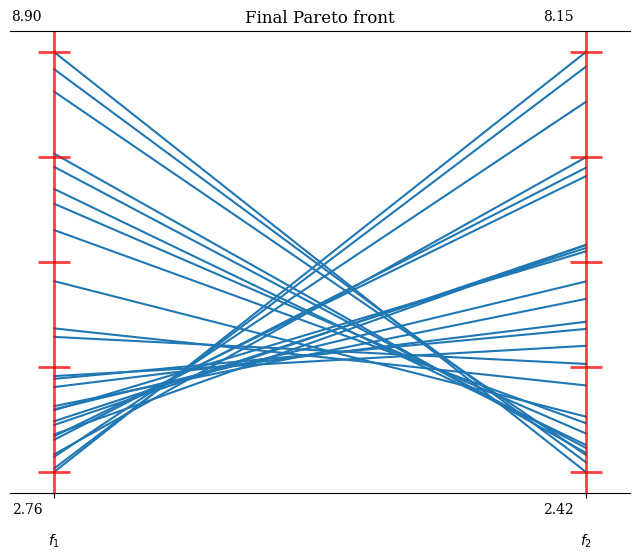

In [8]:
from pymoo.visualization.pcp import PCP
plot = PCP(title="Final Pareto front")
plot.add(res.F)
plot.show()

## Heatmap

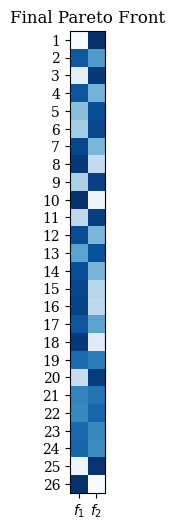

In [9]:
from pymoo.visualization.heatmap import Heatmap
plot = Heatmap(title = "Final Pareto Front")
plot.add(res.F)
plot.show()

<font size=4 color='#d39aed'>
On the x-axis, we have the objectives, and rows are the solutions (here, the Pareto front). Each cell represents the value of a particular objective for a particular solution, with lighter and darker colors showing lower and higher values.
Again we can see the conflict between the two objectives in this plot, when one objective’s color is light, the corresponding color for the other objective tend to be darker.
If we plot this for the entire population, we can visually see the overall distribution of solutions and how good they are, based on the lightness and darkness of the colors across all objectives.
<font>

## Full population of possible solutions representation when the number of objectives increases

<font size=4 color='#d39aed'>
First, we increase the number of objectives to three to observe how the visuals change when the number of objectives increases:
<font>

In [10]:
algorithm_3obj = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

problem_3obj = MOTSP(20, 3)
res_3obj = minimize(problem_3obj,
               algorithm_3obj,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     10 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     13 |  0.000000E+00 |  0.000000E+00 |  0.3225861116 |         ideal
     3 |      300 |     23 |  0.000000E+00 |  0.000000E+00 |  0.1337550954 |         nadir
     4 |      400 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0580435609 |         ideal
     5 |      500 |     36 |  0.000000E+00 |  0.000000E+00 |  0.0959556046 |         ideal
     6 |      600 |     37 |  0.000000E+00 |  0.000000E+00 |  0.0281941441 |         ideal
     7 |      700 |     36 |  0.000000E+00 |  0.000000E+00 |  0.2049272650 |         ideal
     8 |      800 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0689836646 |         ideal
     9 |      900 |     35 |  0.000000E+00 |  0.000000E+00 |  0.2270145378 |         nadir
    10 |     1000 |     44 |  0.000000E+00 |  0.000000E+00 |  0.1268608509 |         ideal

## Scatter plot

<font size=4 color='#d39aed'>
The scatter plot, as mentioned before, is well-suited for representing the full population of possible solutions. However, as the number of objectives increases, it becomes less effective since it can only show up to 3 objectives.
<font>

/usr/local/lib/python3.12/dist-packages/pymoo/core/plot.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**kwargs)


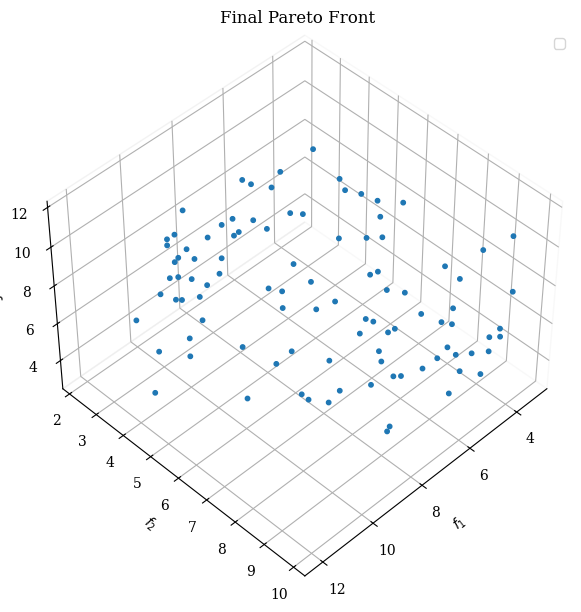

In [11]:
plot = Scatter(title = "Final Pareto Front", tight_layout=True)
plot.add(res_3obj.F, s=10)
plot.legend = True
plot.show()

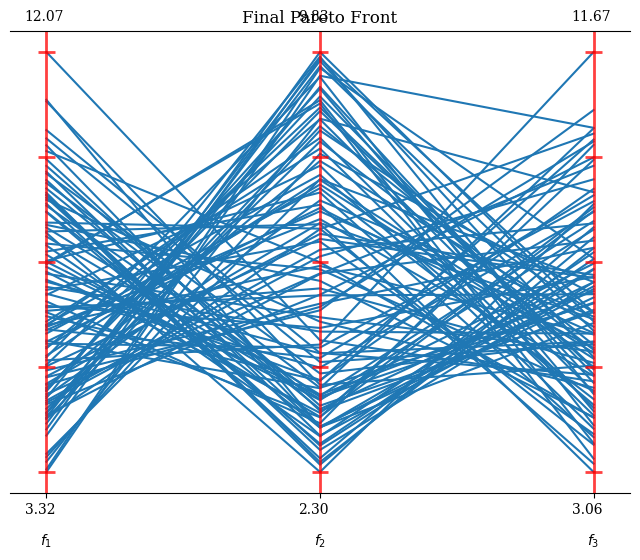

In [12]:
plot = PCP(title = "Final Pareto Front")
plot.add(res_3obj.F)
plot.show()

<font size=4 color='#d39aed'>
While scatter plots can only show up to three objectives, PCPs can handle more by simply adding additional vertical axes (corresponding to the objectives). This doesn’t make interpretation difficult as trade-offs between objectives remain clearly visible, and each solution can still be easily compared across all objectives through its connecting lines.
<font>

## Below, we can see the first population and the final Pareto front in the 3-objective PCP:

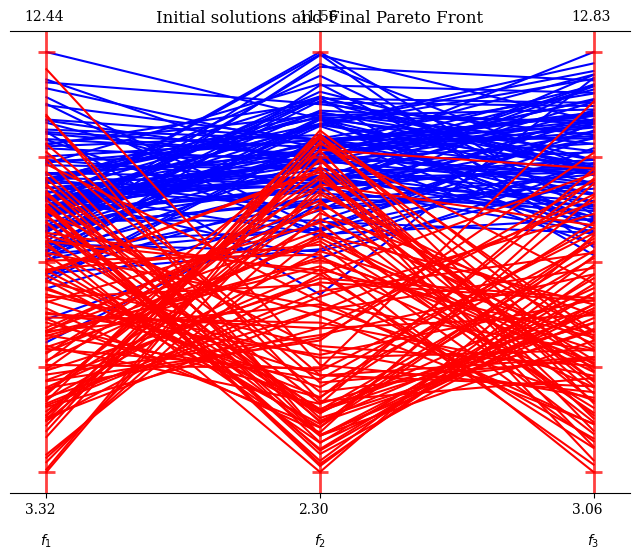

In [13]:
plot = PCP(title = "Initial solutions and Final Pareto Front")
plot.add(res_3obj.history[0].pop.get("F"), color = "blue", label = "All population")
# The final Pareto front
plot.add(res_3obj.F, color = "red", label = "Pareto front")
plot.show()

<font size=4 color='#d39aed'>
In this plot, we can easily see the difference in performance between the final Pareto front and the initial population. Since this is a minimization problem, the better solutions tend to appear toward the bottom, as we aim for lower values on the objective axes.
<font>

## Heatmap

<font size=4 color='#d39aed'>
Heatmaps can handle more objectives by simply adding additional columns, with each column representing the values of all solutions for the corresponding objective.
<font>

# Single solution representation:

## PCP

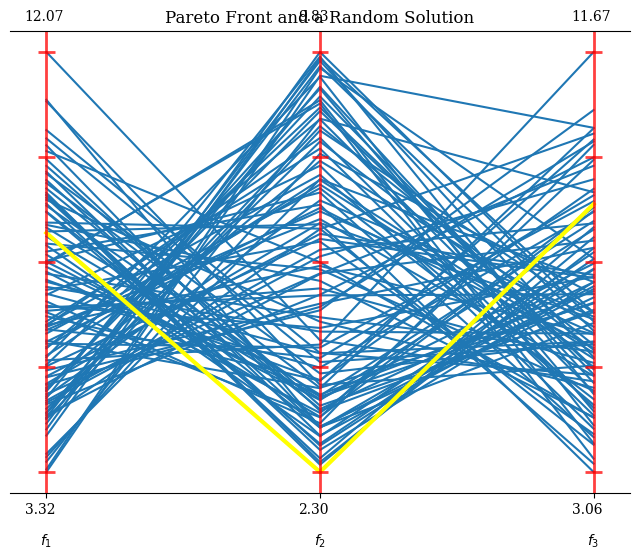

In [14]:
plot = PCP(title = "Pareto Front and a Random Solution")
plot.add(res_3obj.F)
plot.add(res_3obj.F[0], color = "yellow", linewidth = 3)
plot.show()

<font size=4 color='#d39aed'>
This visualization allows us to represent a single solution, and as mentioned, it can effectively display cases with more than two objectives.
<font>

## Petal Diagram

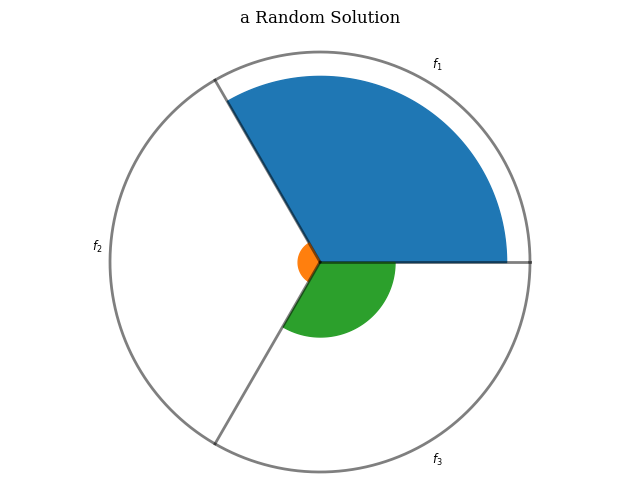

In [15]:
from pymoo.visualization.petal import Petal
min = np.min(res_3obj.F, axis=0)
max = np.max(res_3obj.F, axis=0)
plot = Petal(title = "a Random Solution", bounds = [min,max])
plot.add(res_3obj.F[7])
plot.show()

<font size=4 color='#d39aed'>
In this plot, each solution is represented as a flower, where each petal corresponds to one objective. The size of a colored petal indicates the value of that objective for the solution. This visualization allows us to represent more than two objectives while still viewing them simultaneously for an individual solution. By looking at a single flower, we can easily see how the solution performs across all objectives and how balanced it is among them overall.
<font>

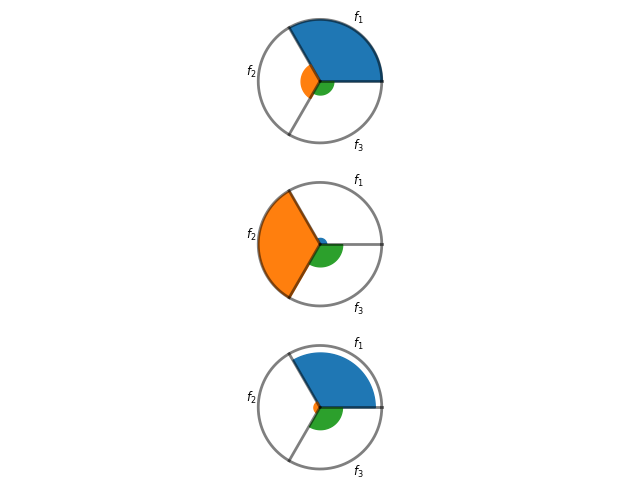

In [18]:
min = np.min(res_3obj.F, axis=0)
max = np.max(res_3obj.F, axis=0)
plot = Petal(bounds=[min, max])
plot.add(res_3obj.F[1], label="Solution 4")
plot.add(res_3obj.F[4], label="Solution 5")
plot.add(res_3obj.F[7], label="Solution 6")
plot.show()

<font size=4 color='#d39aed'>
In this plot, when comparing individual solutions, we can clearly observe the trade-offs between objectives. The Pareto front solutions do not dominate one another. None of the solutions shown performs better than the others across all objectives.
<font>

## Radviz

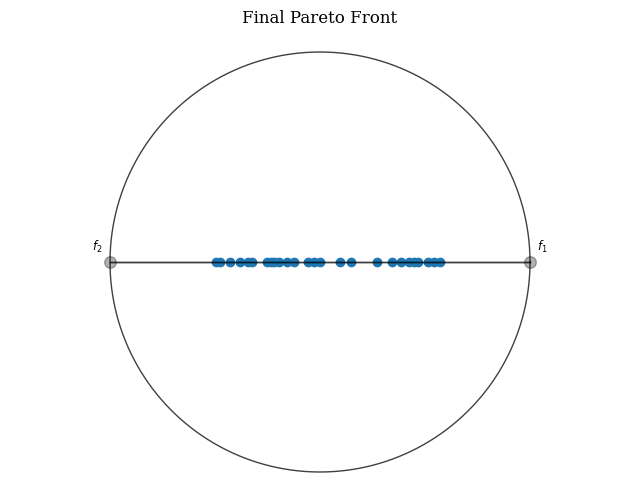

In [19]:
from pymoo.visualization.radviz import Radviz
Radviz(title = "Final Pareto Front").add(res.F).show()

<font size=4 color='#d39aed'>In the Radviz plot, each solution is positioned based on its performance on each objective, the closer it is to a specific objective base, the better it performs on that objective. This makes trade-offs and balances between objectives easy to observe. It is also straightforward to compare different solutions, as each one appears as a single point with a meaningful position. When the number of objectives increases, more objective bases can simply be added on the circle without issue. The points near the center represent solutions that are balanced across the objectives.

We can also visualize the convergence of each objective. We'll plot the fitness of the first individual in the Pareto front over evolution. Note that this isn't the best value for each objective independently, but rather all the objective values of a single individual.

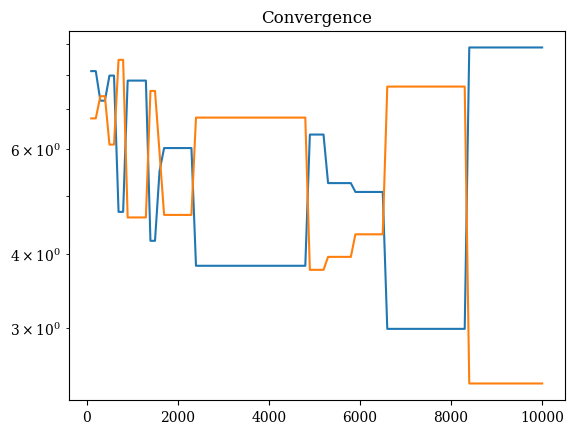

In [20]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

As the number of dimensions grows, visualizing the convergence across all objectives becomes difficult. One recently proposed metric known as the "running metric" evaluates non-dominated sets from each generation relative to previously recorded sets. This gives an idea of how much the Pareto front has moved in any generation. For visualizing this running metric, each ND set is normalized by the final ND set after a certain number of generations. The difference between intervals then gives an idea if the algorithm is converging.

<img src="https://github.com/d9w/evolution/raw/master/imgs/running_metric.png">

Blank, Julian, and Kalyanmoy Deb. "A running performance metric and termination criterion for evaluating evolutionary multi-and many-objective optimization algorithms." Proc. IEEE World Congr. Comput. Intell.(WCCI). 2020.

https://www.egr.msu.edu/~kdeb/papers/c2020003.pdf

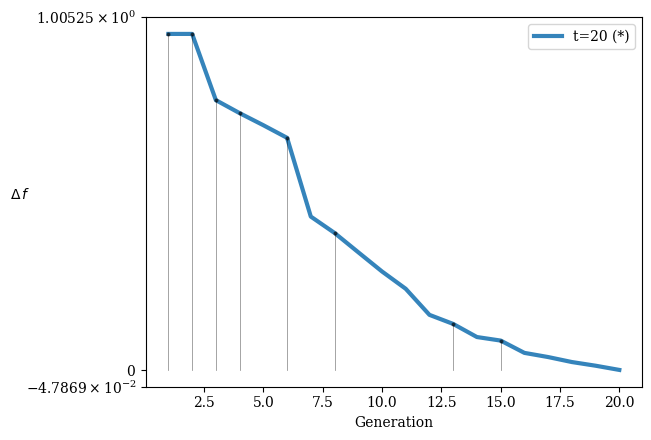

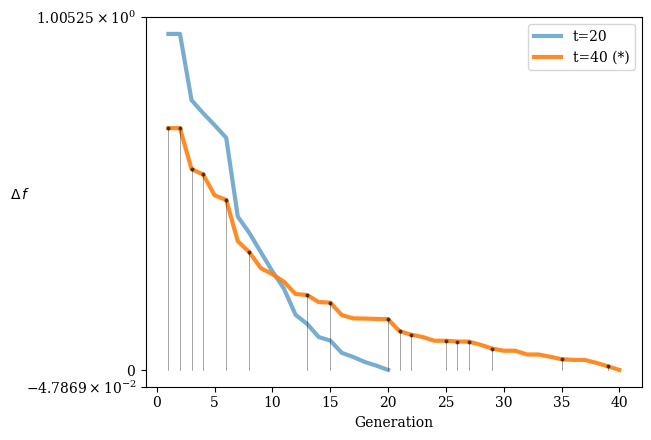

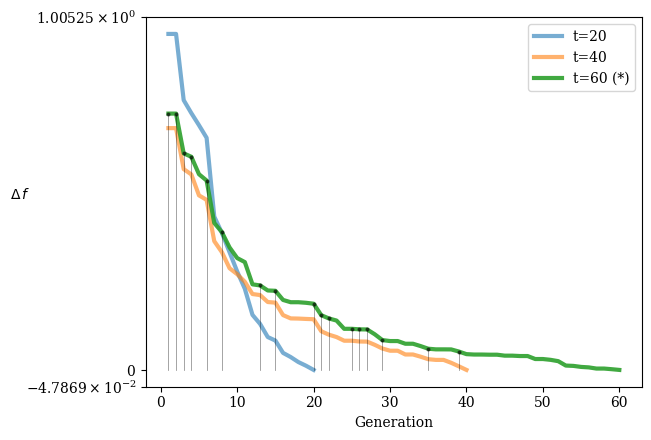

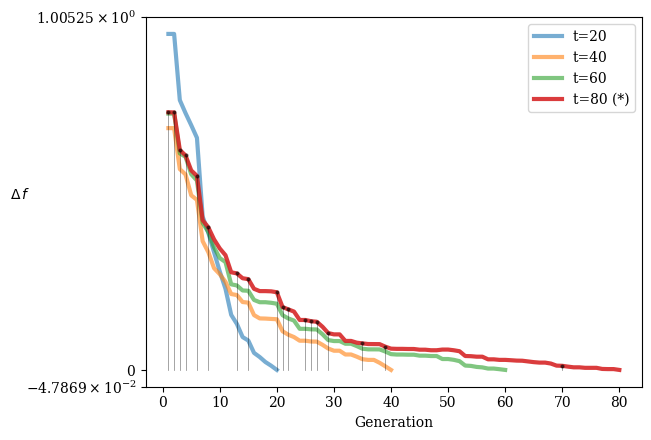

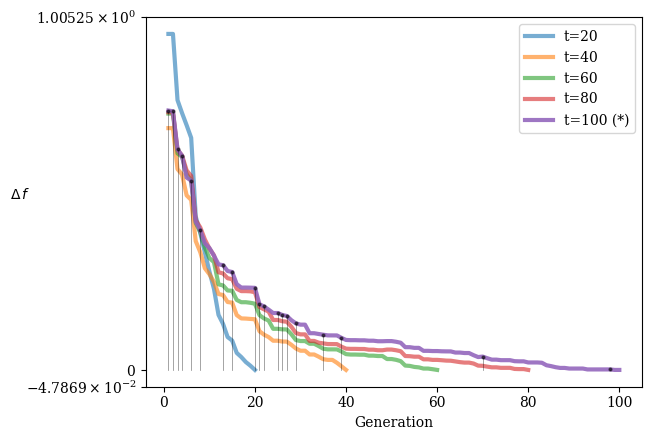

In [21]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=20,
                        n_plots=5,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.update(algorithm)

# Best performance achieved on the 3-objective problem by experimenting with NSGA2 hyperparameters

<font size=4 color='#d39aed'>Since the number of objectives increased from 2 to 3, it makes sense to increase the population size (from 100 to 200), as a more complex and higher-dimensional Pareto front needs a larger population to cover it. It also makes sense to run the algorithm for more generations (from 100 to 1000), since more iterations are needed for the population to evolve and spread over the more complex Pareto front.

In [22]:
algorithm_3obj_tuned = NSGA2(
    pop_size=200,
    n_offsprings=200,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

problem_3obj_tuned = MOTSP(20, 3)
res_3obj_tuned = minimize(problem_3obj_tuned,
               algorithm_3obj_tuned,
               ("n_gen", 1000),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |     22 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      400 |     29 |  0.000000E+00 |  0.000000E+00 |  0.1259577892 |         nadir
     3 |      600 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0668285353 |         ideal
     4 |      800 |     27 |  0.000000E+00 |  0.000000E+00 |  0.1231198608 |         ideal
     5 |     1000 |     22 |  0.000000E+00 |  0.000000E+00 |  0.2121502346 |         ideal
     6 |     1200 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0728713444 |         ideal
     7 |     1400 |     32 |  0.000000E+00 |  0.000000E+00 |  0.0027367893 |         ideal
     8 |     1600 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0081792703 |         ideal
     9 |     1800 |     45 |  0.000000E+00 |  0.000000E+00 |  0.0237201265 |         ideal
    10 |     2000 |     41 |  0.000000E+00 |  0.000000E+00 |  0.0816867462 |         ideal

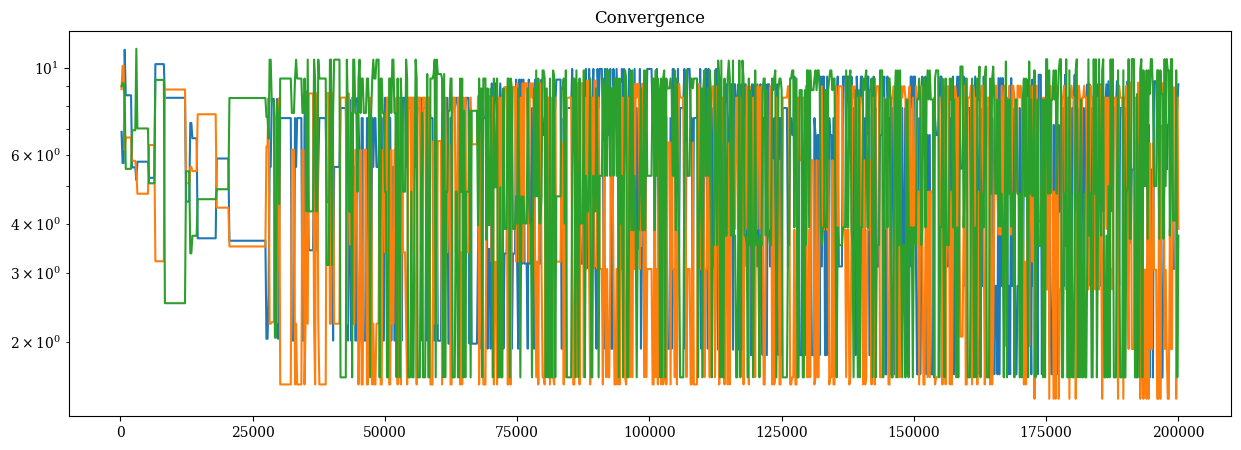

In [27]:
n_evals = np.array([e.evaluator.n_eval for e in res_3obj_tuned.history])
opt = np.array([e.opt[0].F for e in res_3obj_tuned.history])
plt.figure(figsize=(15,5)) # increase width for readability
plt.title("Convergence")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

# Petal Diagrams of 2 random solutions in the Pareto front:

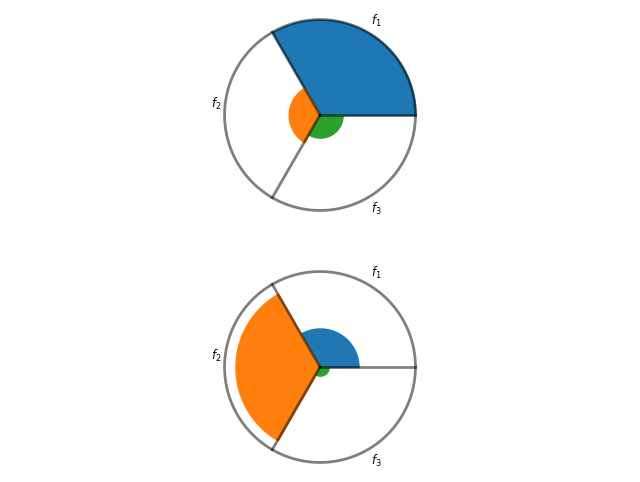

In [28]:
min = np.min(res_3obj_tuned.F, axis=0)
max = np.max(res_3obj_tuned.F, axis=0)
plot = Petal(bounds=[min, max])
plot.add(res_3obj_tuned.F[0], label="Solution 4")
plot.add(res_3obj_tuned.F[7], label="Solution 6")
plot.show()

## Running Metric

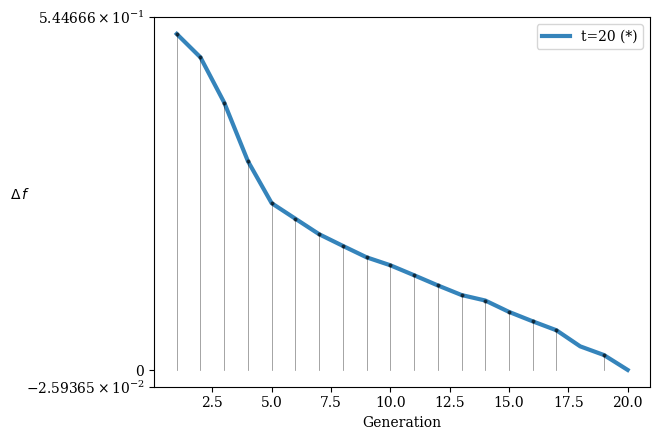

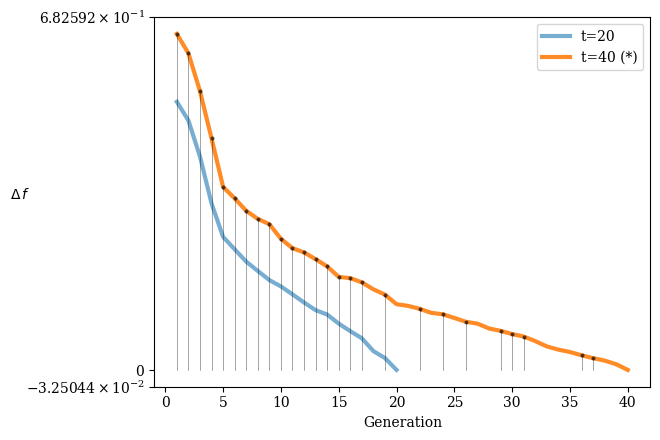

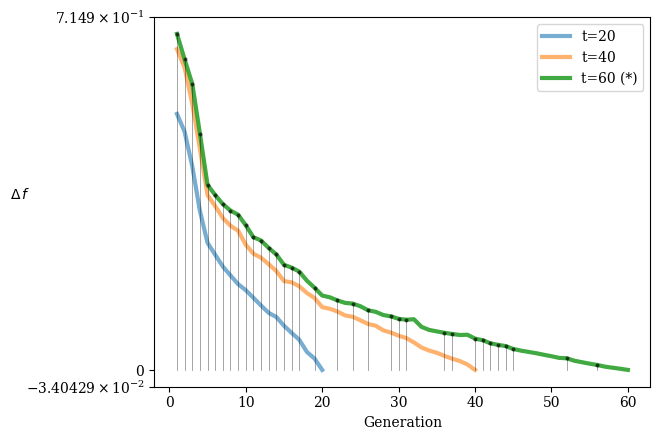

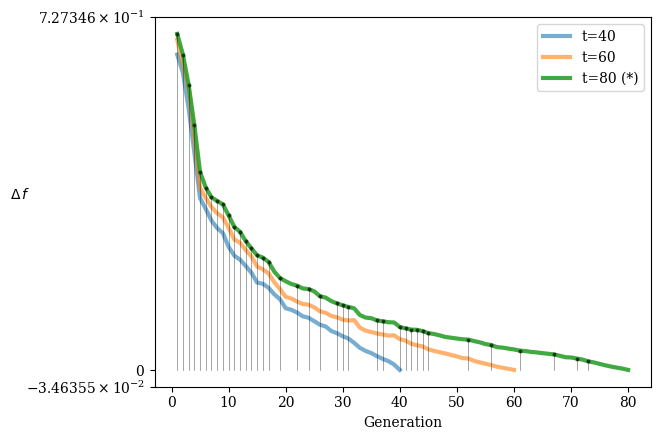

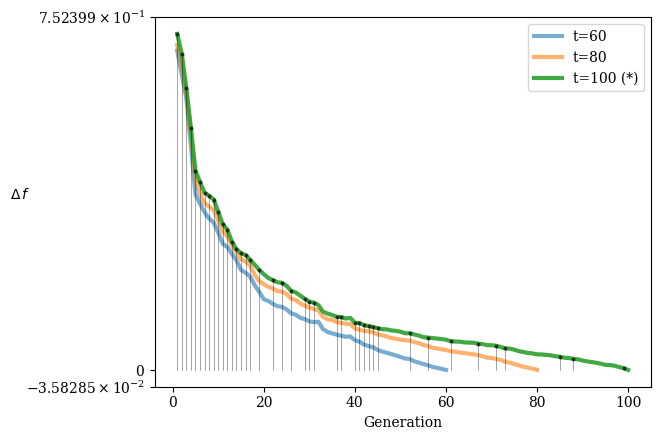

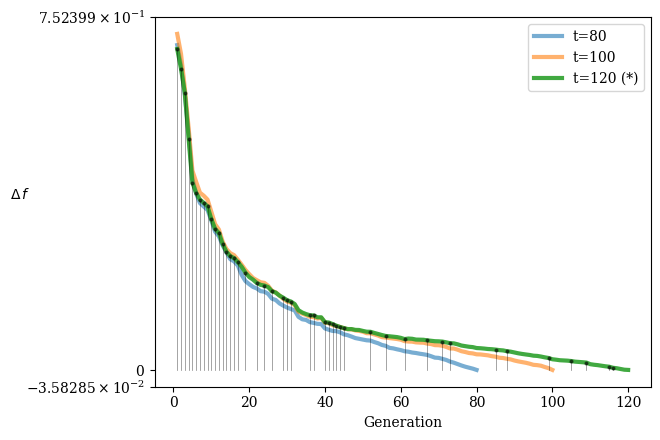

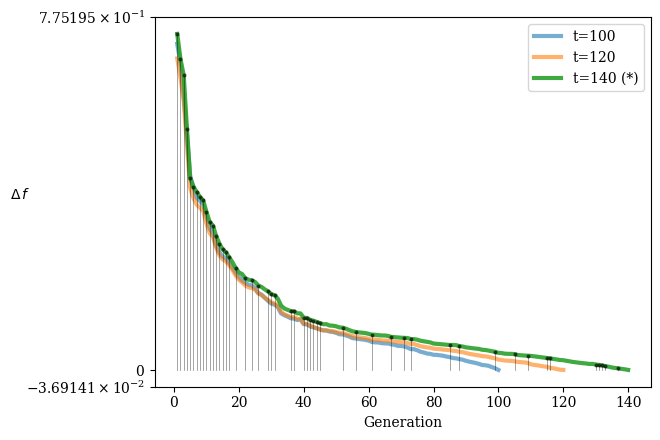

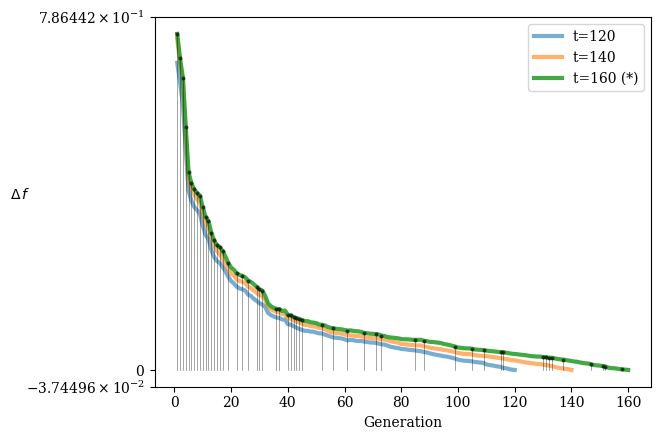

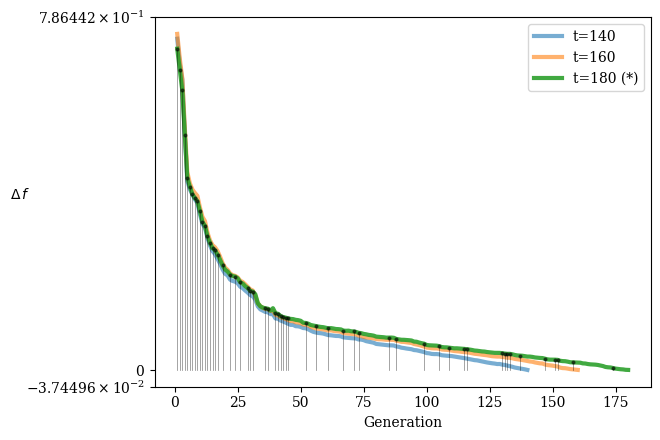

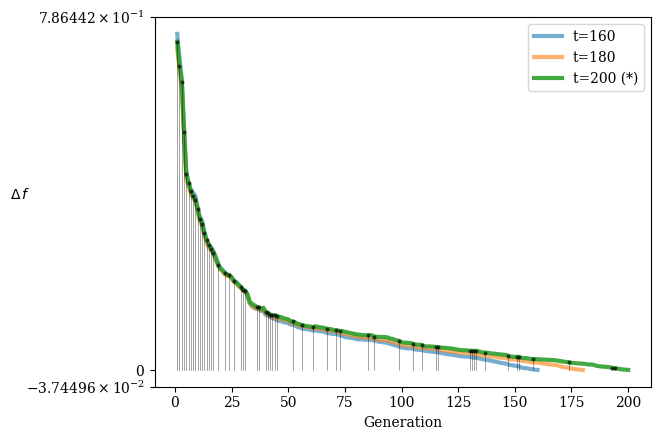

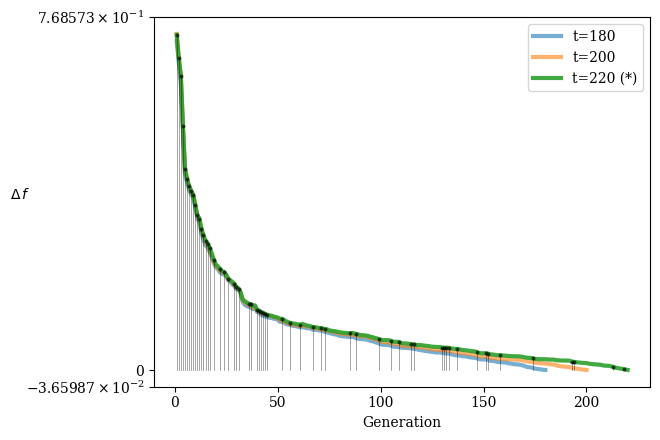

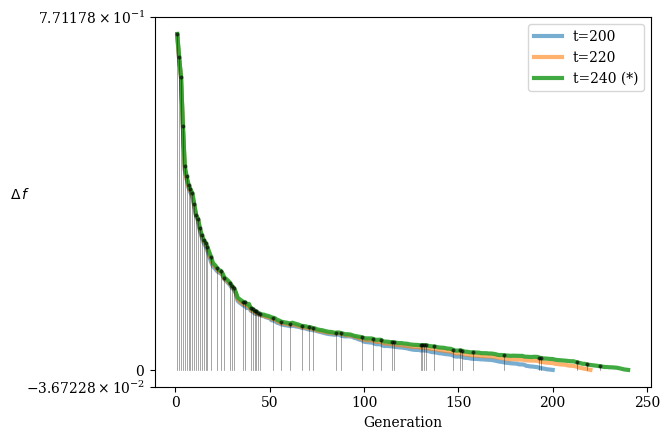

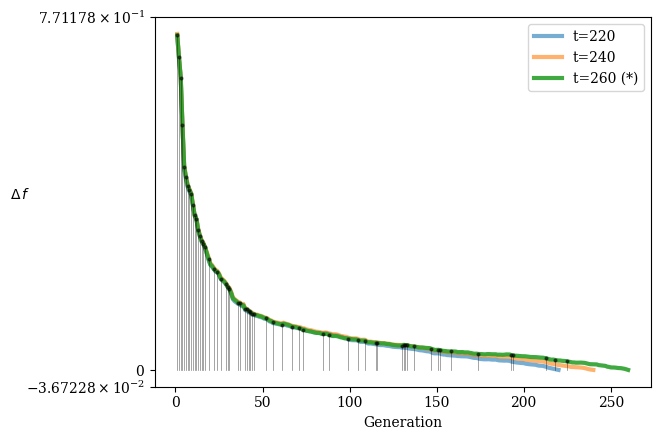

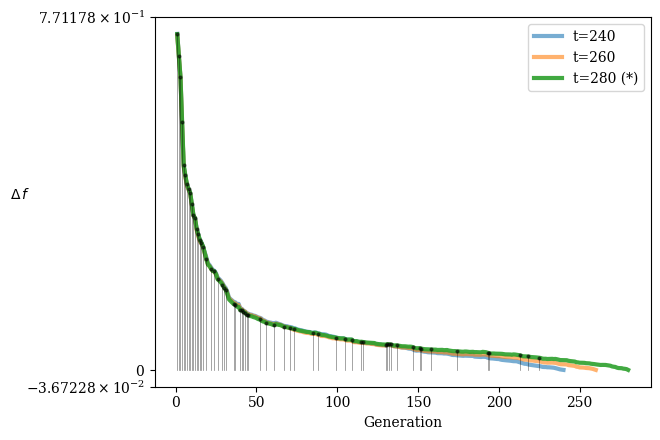

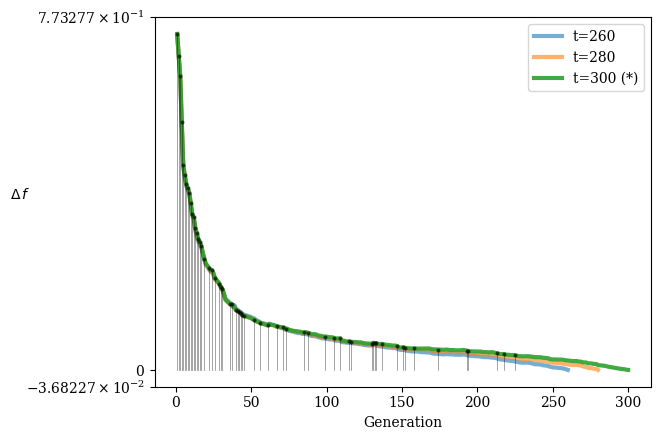

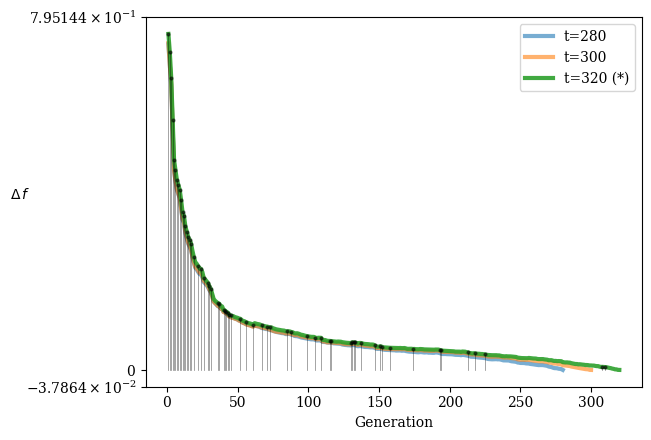

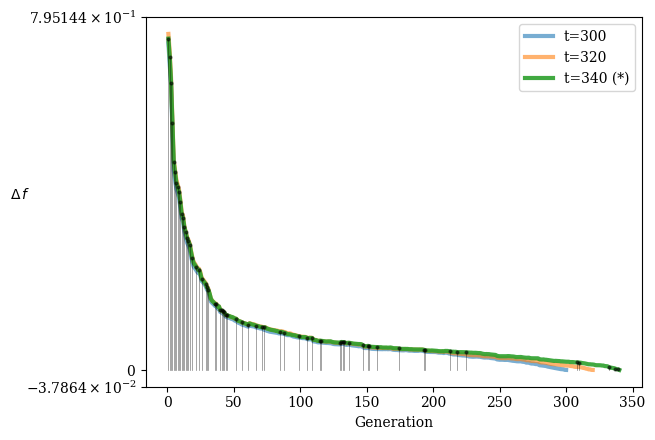

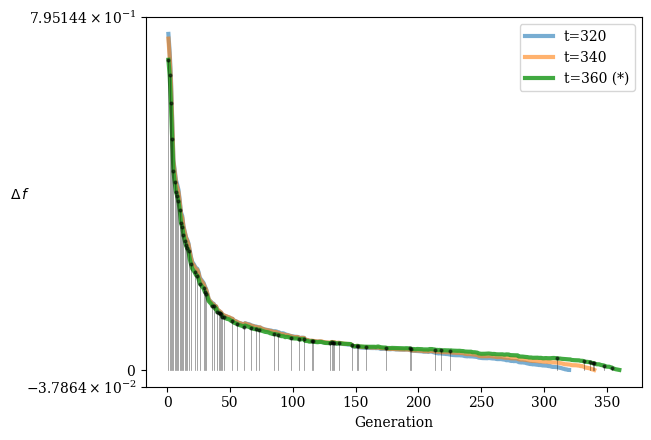

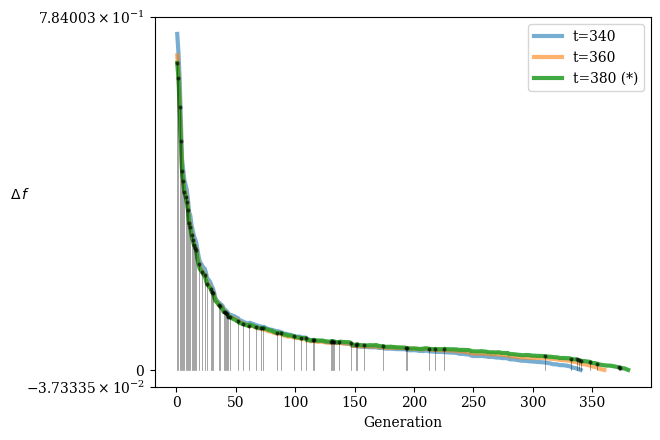

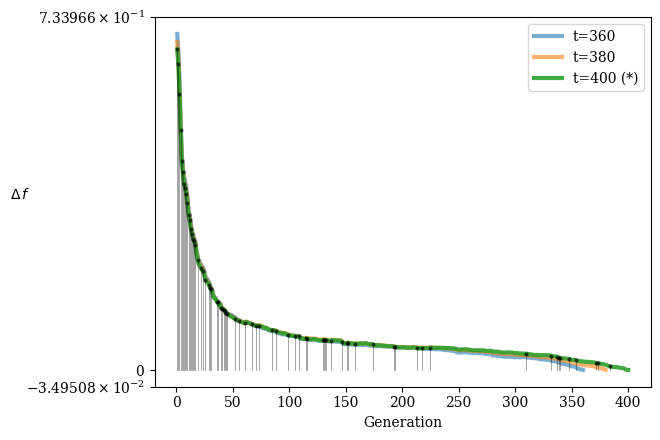

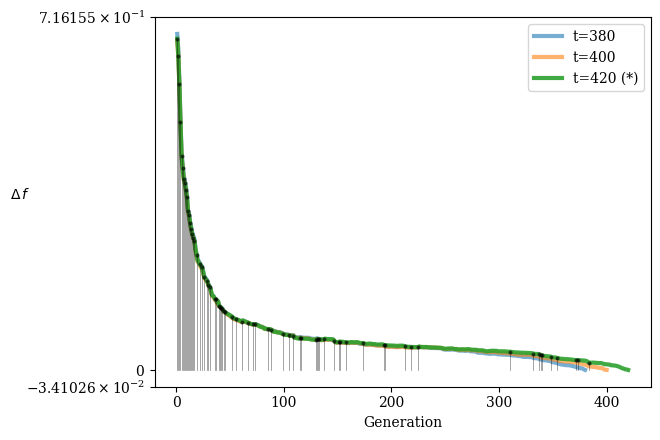

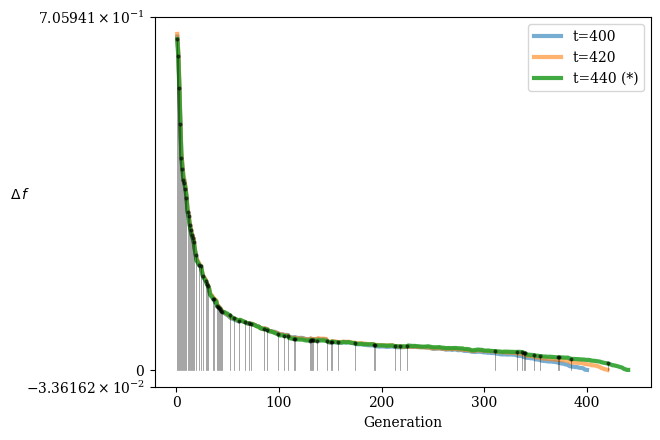

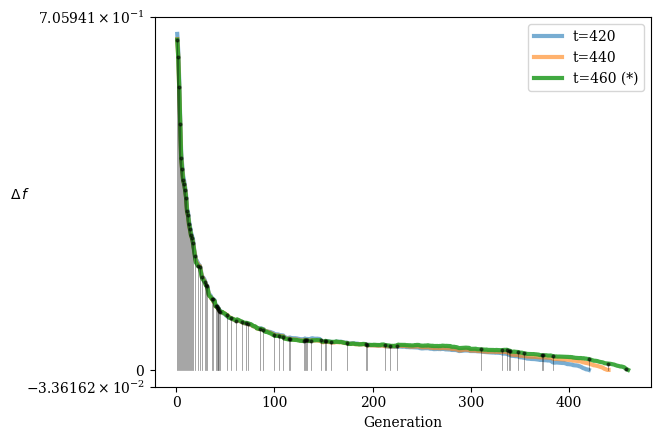

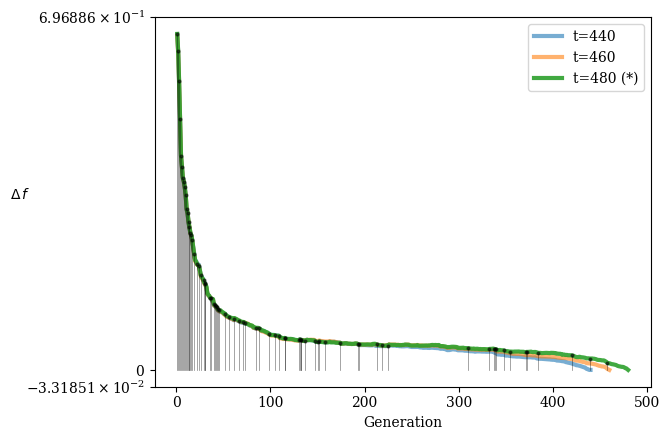

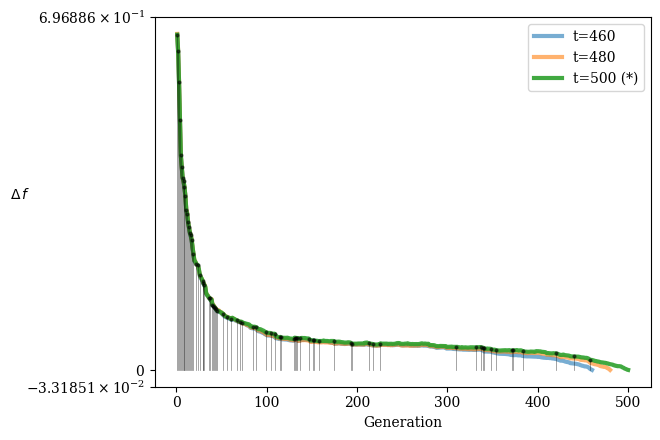

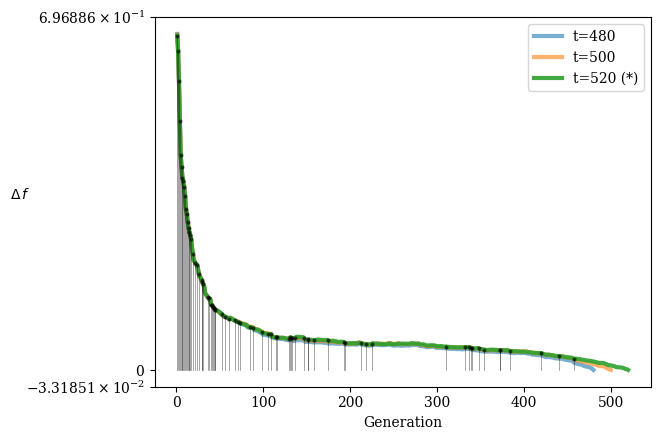

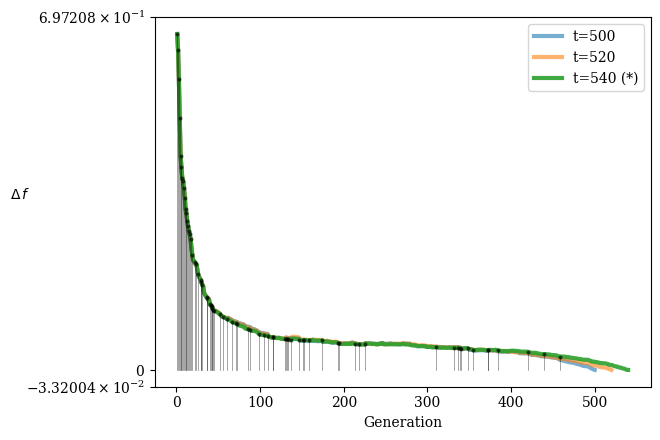

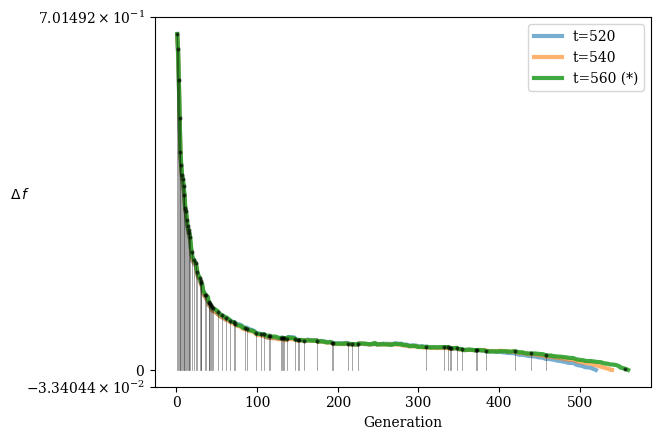

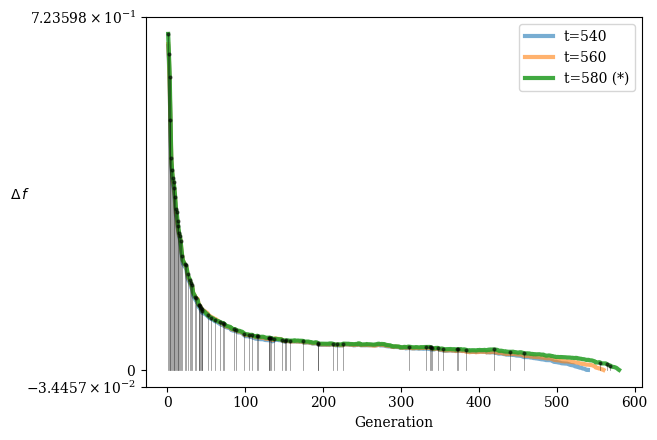

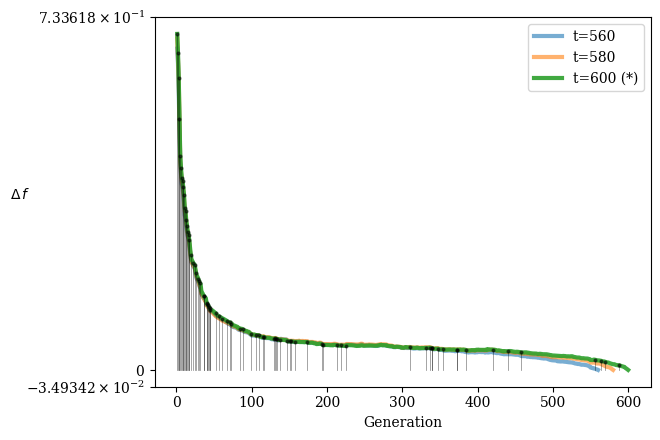

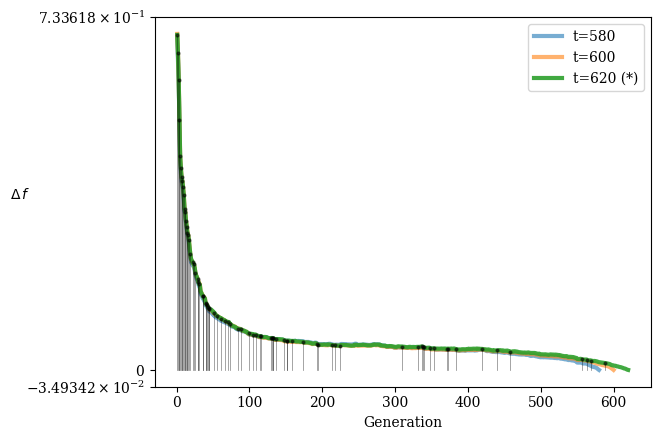

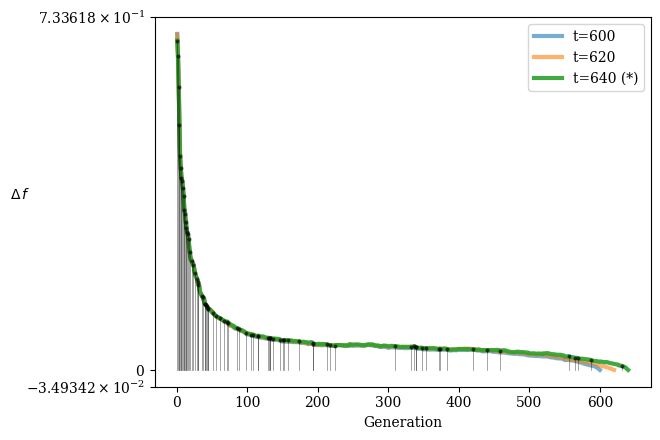

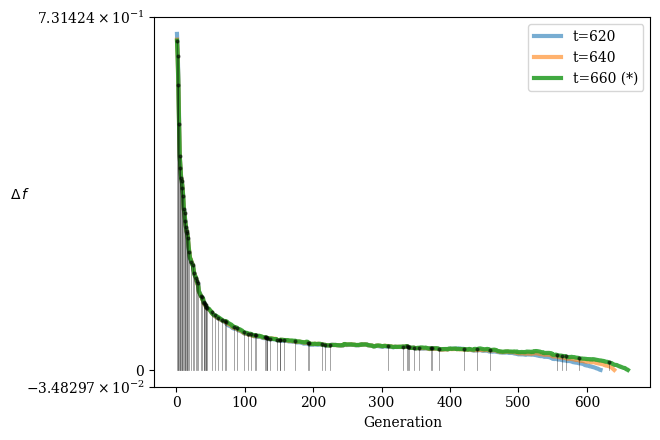

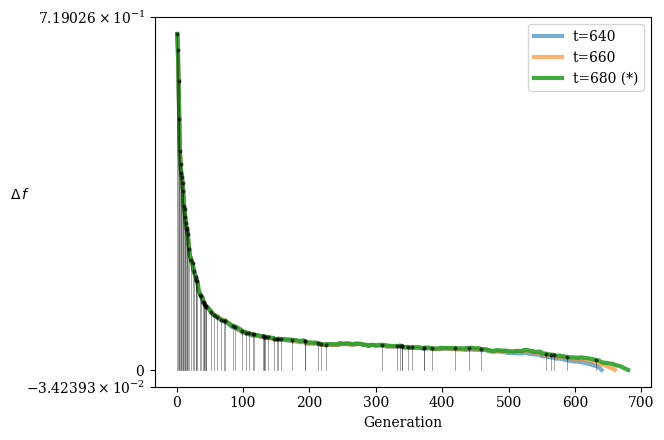

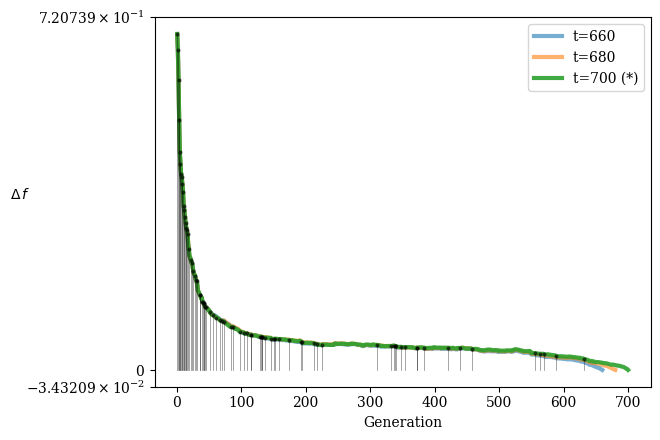

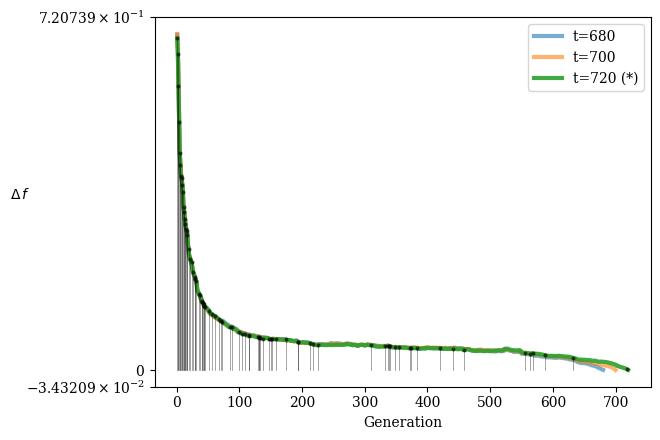

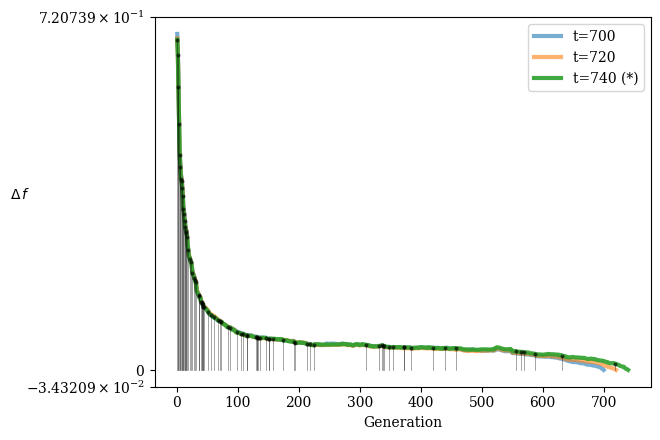

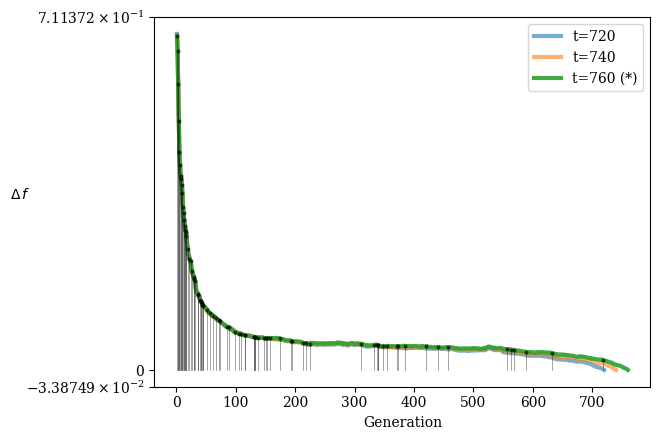

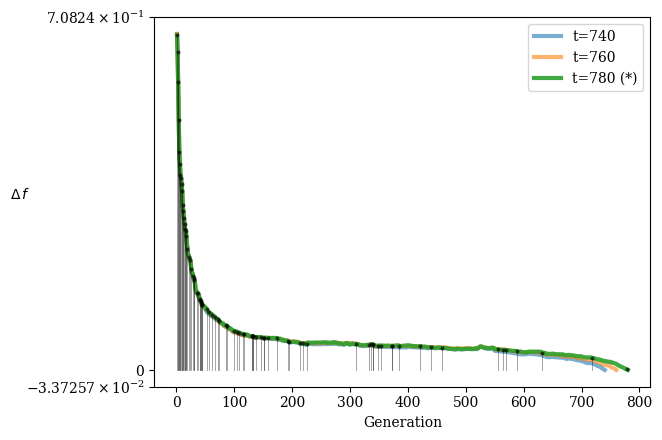

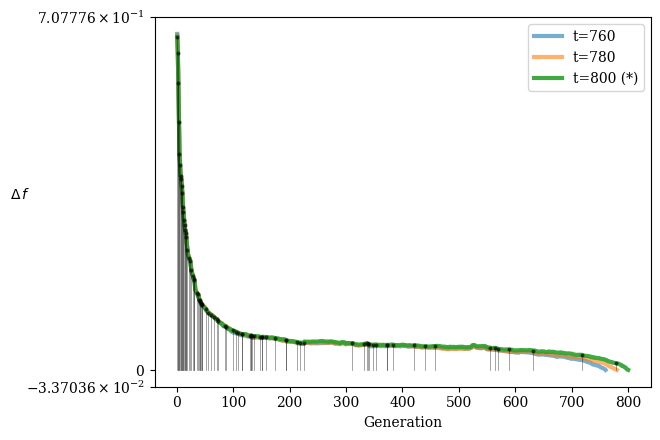

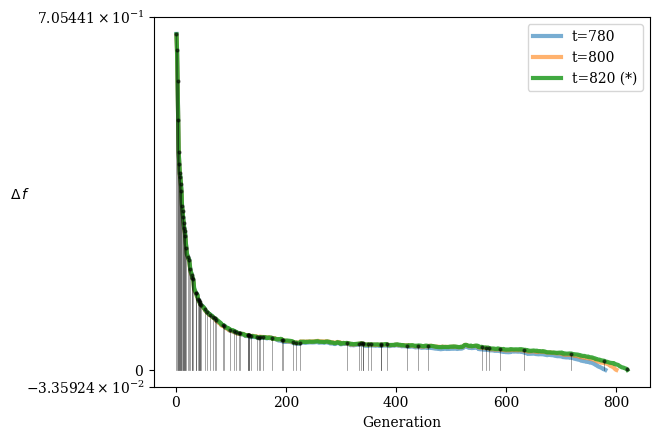

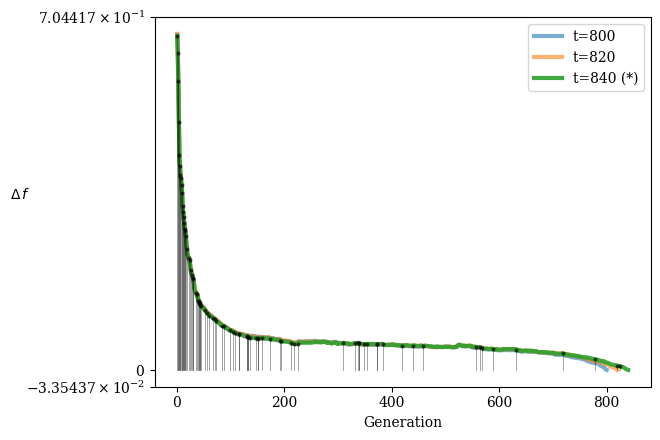

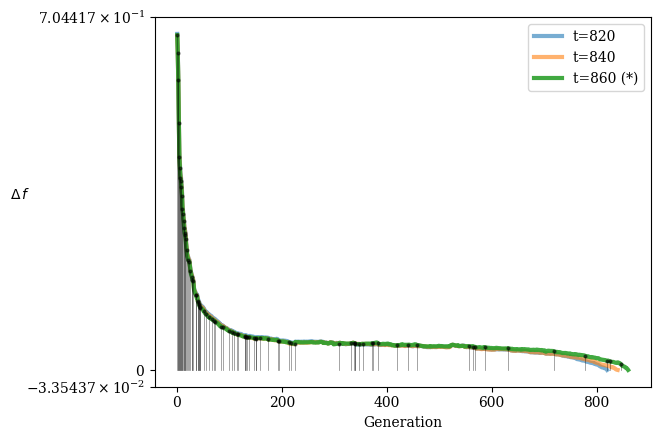

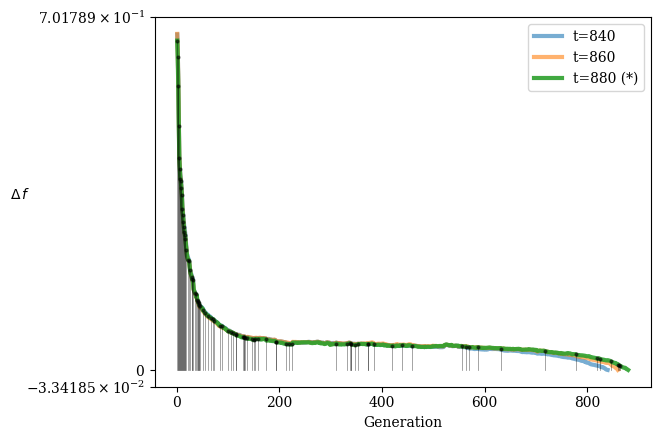

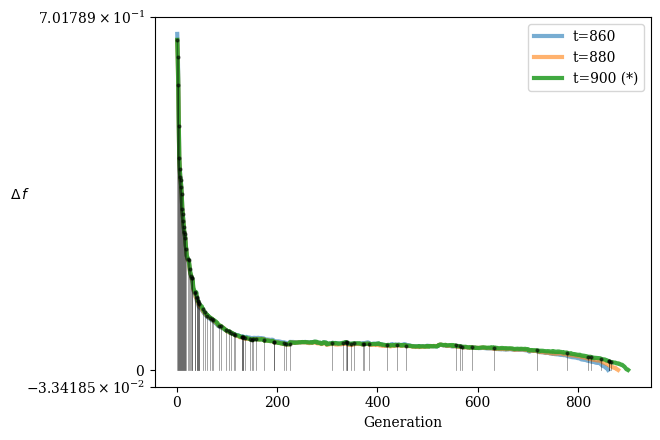

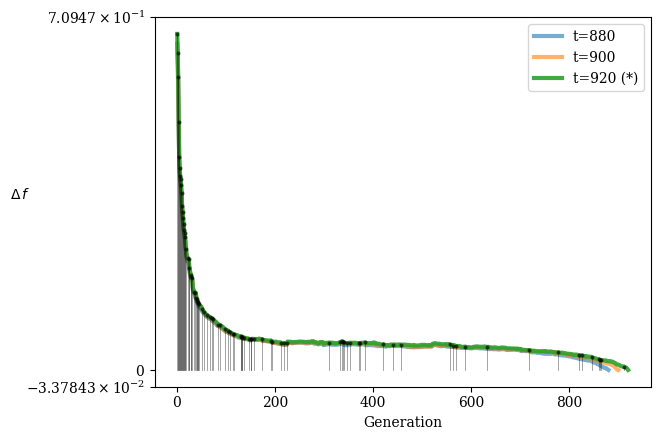

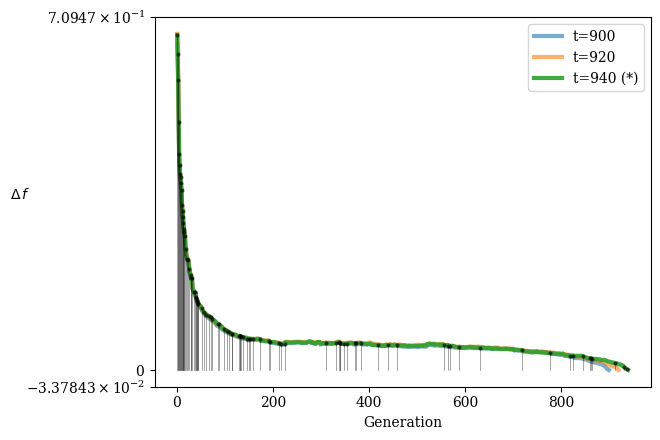

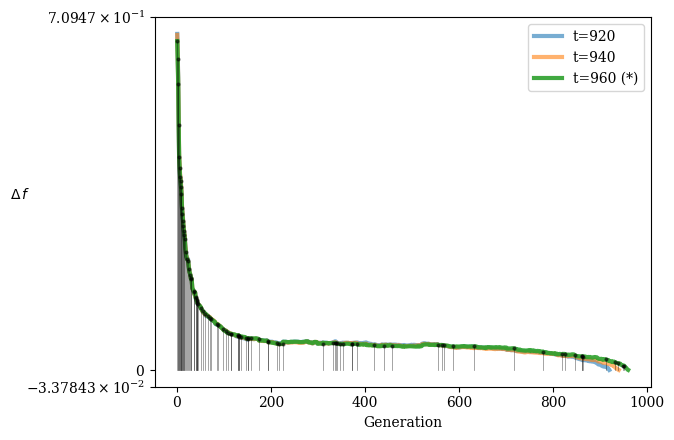

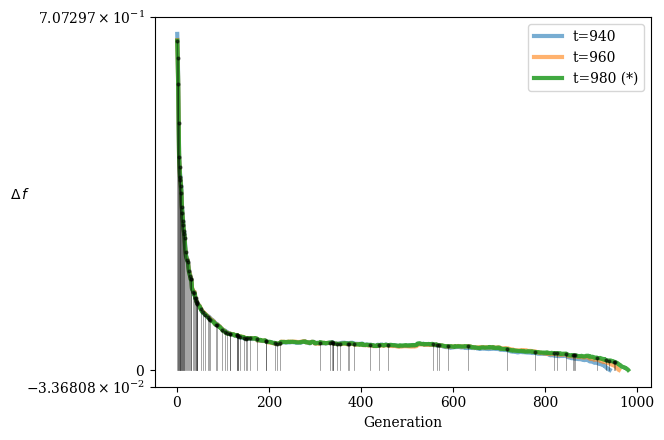

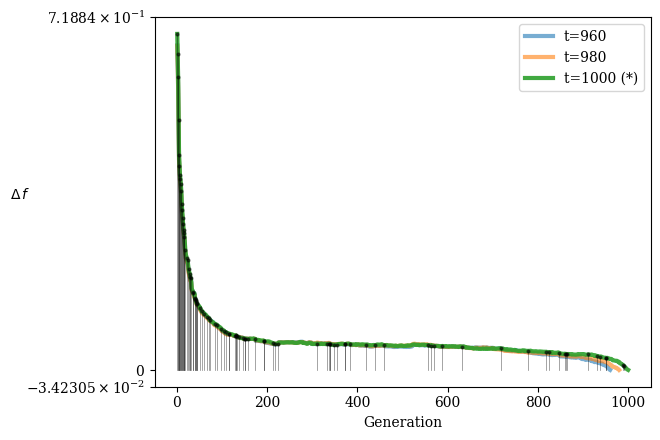

In [29]:
running = RunningMetricAnimation(delta_gen=20,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in res_3obj_tuned.history:
    running.update(algorithm)

<font size=4 color='#d39aed'>Based on the plots, the 3-objective search space is more complex and there are more conflicts (due to more objectives) and convergence takes longer or may not occur (as it may keep flip-flopping between the objectives).

/usr/local/lib/python3.12/dist-packages/pymoo/core/plot.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**kwargs)


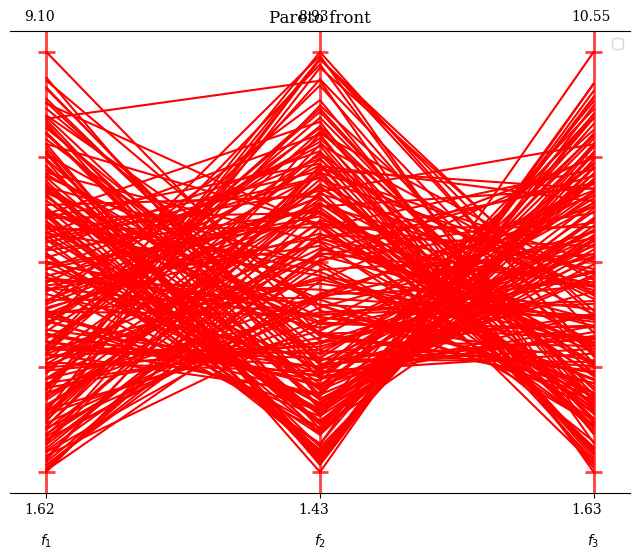

In [30]:
plot = PCP(title = "Pareto front", legend = True)
plot.add(res_3obj_tuned.F, color = "red")
plot.show()

In [31]:
print("Number of solutions in final Pareto front:", len(res_3obj_tuned.F))

Number of solutions in final Pareto front: 200


<font size=4 color='#d39aed'>This shows that all final solutions are non-dominated, which means it’s diverse but has weak dominance pressure for selection. As the number of objectives increases, convergence becomes harder. Therefore with even more tuning and number of generations, it still may not converge, and just flip-flops between objectives and improve one objective while sacrificing others.

<div class="alert alert-success">
    <h3>Exercise 2</h3>

Increase the number of objectives and observe the convergence of NSGA-II. Roughly, how much does each objective change convergence speed?
</div>

## 3 Objectives

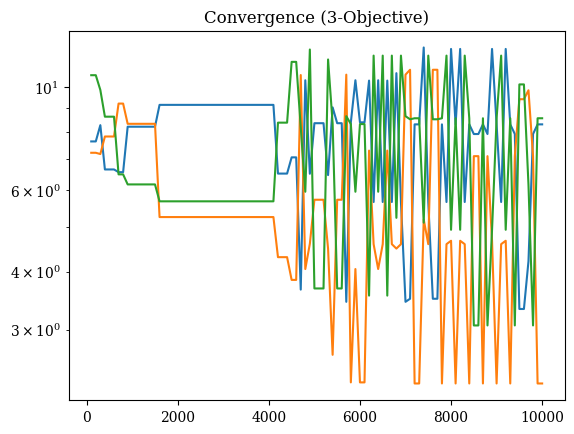

In [43]:
n_evals = np.array([e.evaluator.n_eval for e in res_3obj.history])
opt = np.array([e.opt[0].F for e in res_3obj.history])

plt.title("Convergence (3-Objective)")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

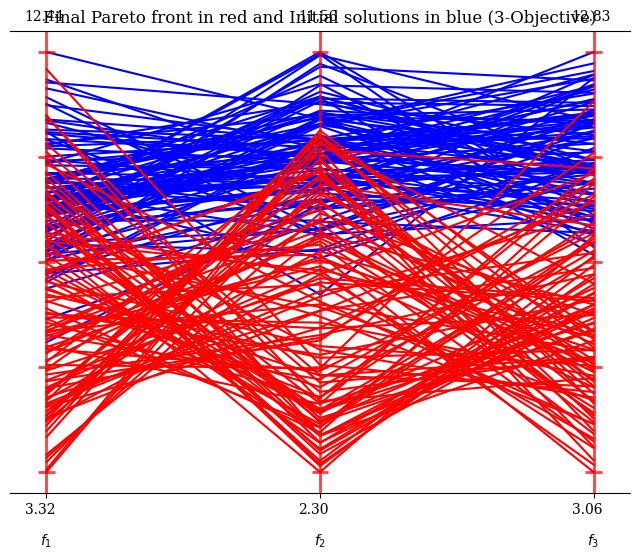

In [44]:
plot = PCP(title = "Final Pareto front in red and Initial solutions in blue (3-Objective)")
plot.add(res_3obj.history[0].pop.get("F"), color = "blue")
plot.add(res_3obj.F, color = "red")
plot.show()

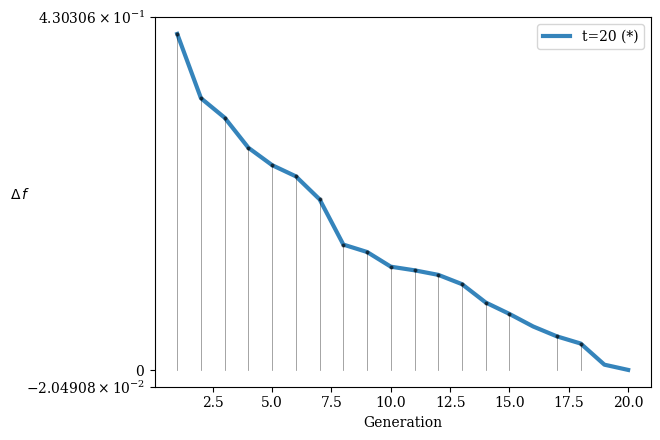

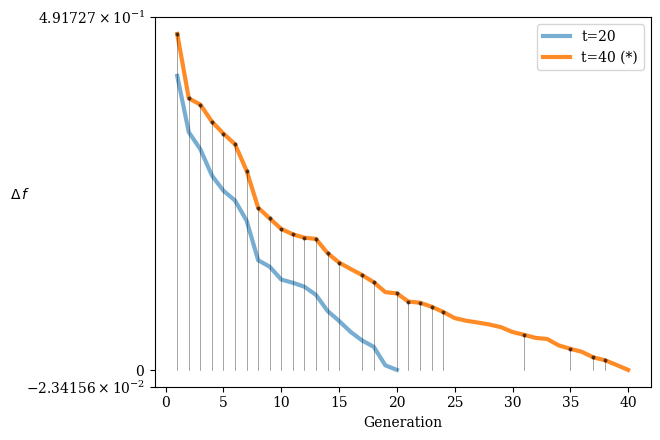

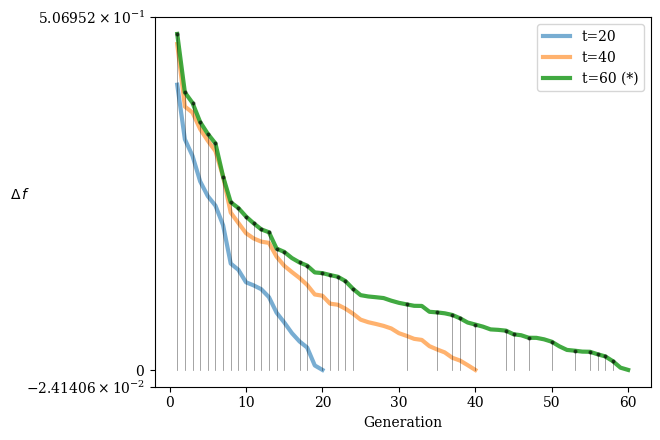

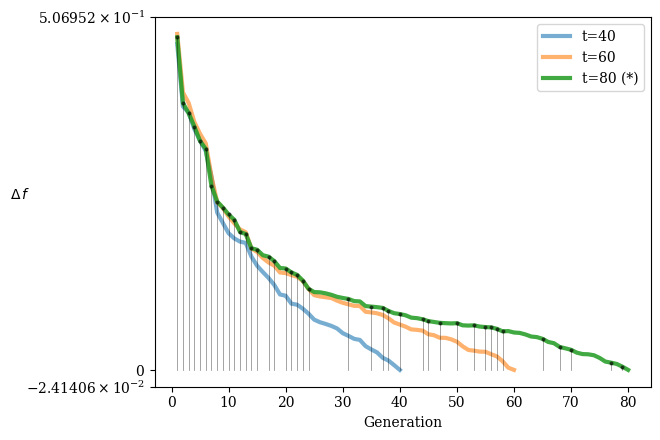

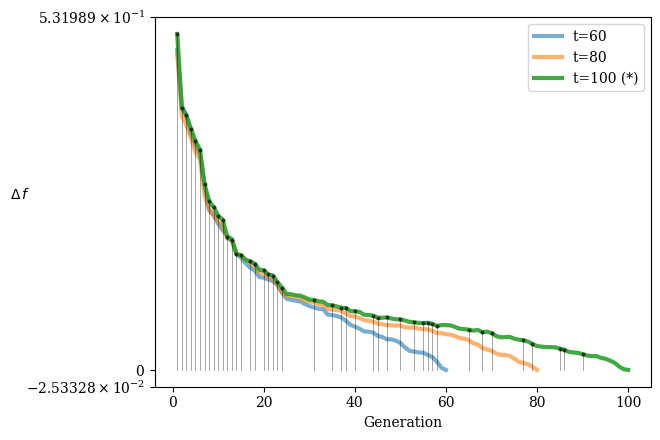

In [34]:
running = RunningMetricAnimation(delta_gen=20,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in res_3obj.history:
    running.update(algorithm)

## 4 Objectives

In [35]:
algorithm_4obj = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

problem_4obj = MOTSP(20, 4)
res_4obj = minimize(problem_4obj,
               algorithm_4obj,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     35 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     41 |  0.000000E+00 |  0.000000E+00 |  0.2567054226 |         ideal
     3 |      300 |     48 |  0.000000E+00 |  0.000000E+00 |  0.1574345059 |         ideal
     4 |      400 |     53 |  0.000000E+00 |  0.000000E+00 |  0.0915322295 |         ideal
     5 |      500 |     58 |  0.000000E+00 |  0.000000E+00 |  0.0131947855 |         ideal
     6 |      600 |     71 |  0.000000E+00 |  0.000000E+00 |  0.1293049564 |         ideal
     7 |      700 |     88 |  0.000000E+00 |  0.000000E+00 |  0.0555324316 |         nadir
     8 |      800 |     88 |  0.000000E+00 |  0.000000E+00 |  0.0534835040 |         ideal
     9 |      900 |     99 |  0.000000E+00 |  0.000000E+00 |  0.0445930720 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0588682455 |         nadir

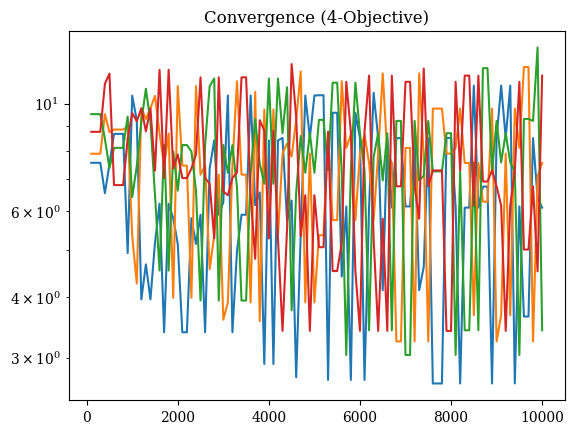

In [45]:
n_evals = np.array([e.evaluator.n_eval for e in res_4obj.history])
opt = np.array([e.opt[0].F for e in res_4obj.history])

plt.title("Convergence (4-Objective)")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

## Final Pareto front in red and Initial solutions in blue (4-Objective)

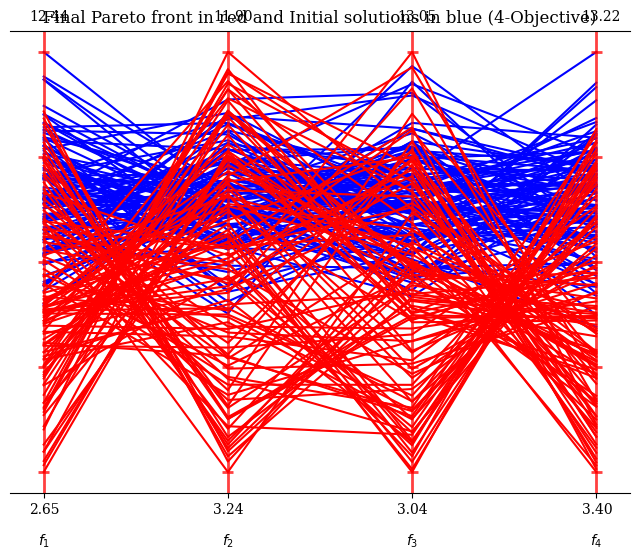

In [46]:
plot = PCP(title = "Final Pareto front in red and Initial solutions in blue (4-Objective)")
plot.add(res_4obj.history[0].pop.get("F"), color = "blue", label = "Final solutions")
plot.add(res_4obj.F, color = "red", label = "Final Pareto front")
plot.show()

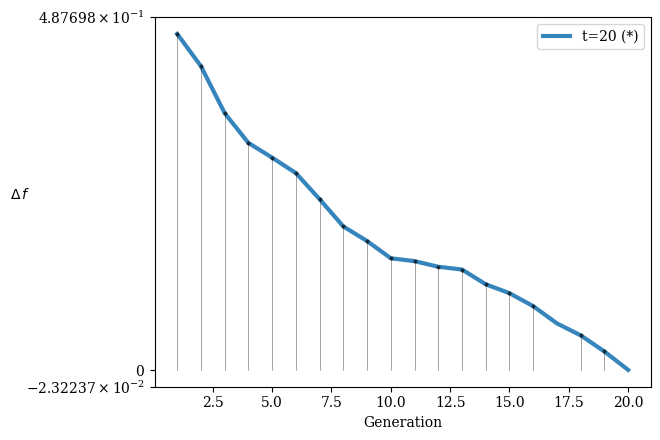

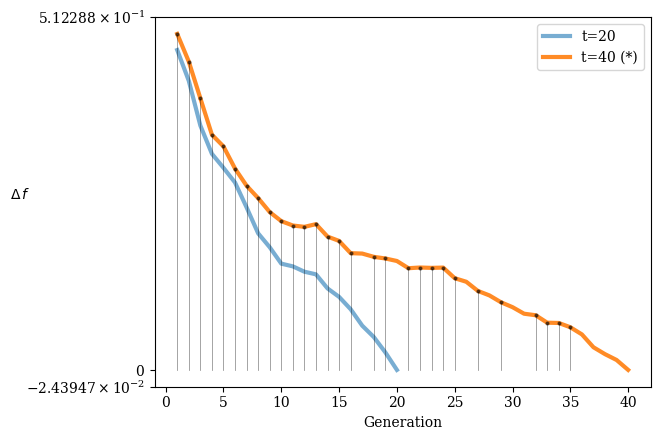

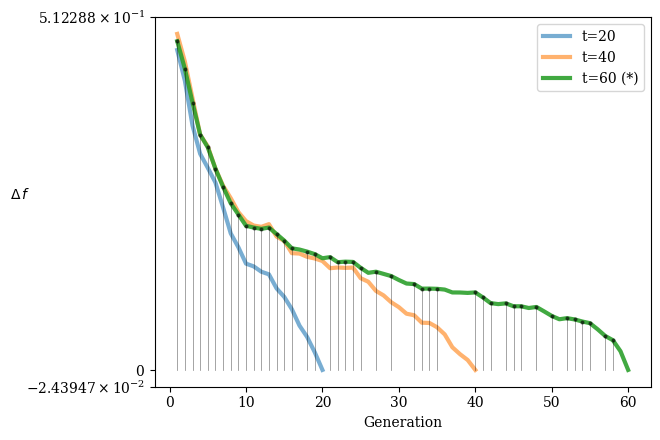

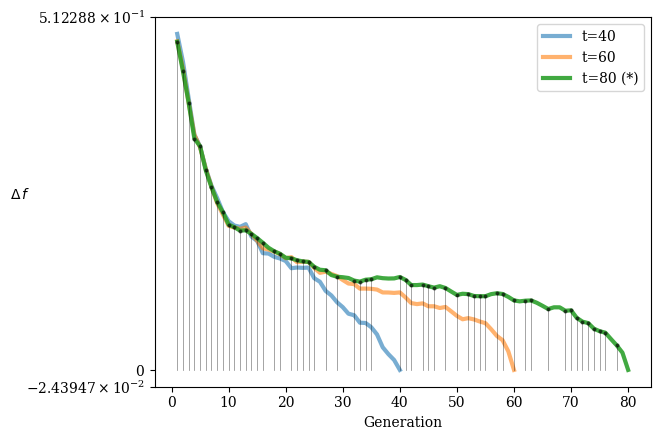

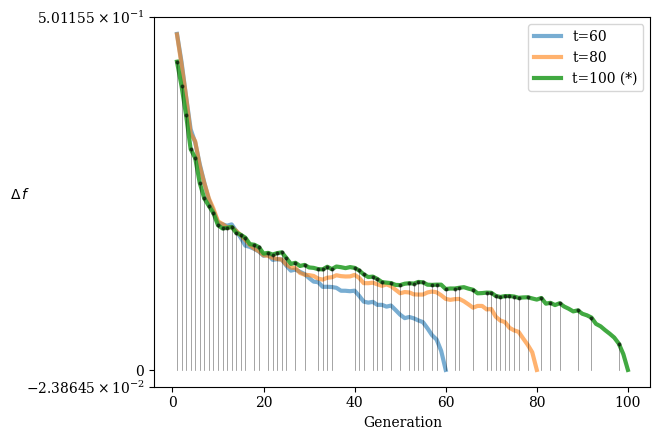

In [38]:
running = RunningMetricAnimation(delta_gen=20,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in res_4obj.history:
    running.update(algorithm)

## 5 Objectives

In [39]:
algorithm_5obj = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

problem_5obj = MOTSP(20, 5)
res_5obj = minimize(problem_5obj,
               algorithm_5obj,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     38 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0939920243 |         ideal
     3 |      300 |     74 |  0.000000E+00 |  0.000000E+00 |  0.2437155051 |         ideal
     4 |      400 |     97 |  0.000000E+00 |  0.000000E+00 |  0.1254702301 |         ideal
     5 |      500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.2104768240 |         ideal
     6 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.1315245971 |         ideal
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0863294965 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0370888599 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0445210045 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0449965015 |         ideal

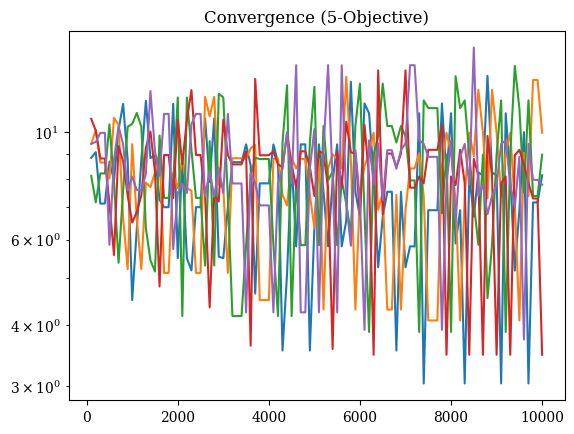

In [47]:
n_evals = np.array([e.evaluator.n_eval for e in res_5obj.history])
opt = np.array([e.opt[0].F for e in res_5obj.history])

plt.title("Convergence (5-Objective)")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

## Final Pareto front in red and Initial solutions in blue (5-Objective)

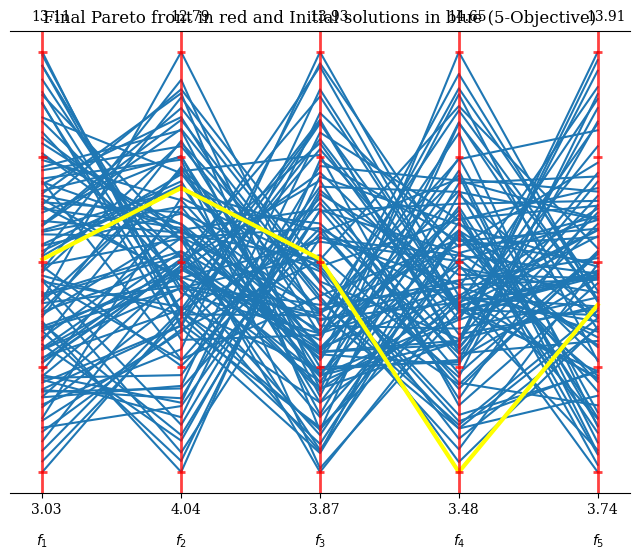

In [48]:
plot = PCP(title = "Final Pareto front in red and Initial solutions in blue (5-Objective)")
plot.add(res_5obj.F)
plot.add(res_5obj.F[0], color = "yellow", linewidth = 3)
plot.show()

<font size=4 color='#d39aed'>In the above two plots, We can see a flip-flopping behavior between the objectives, the algorithm keeps trying to optimize them and find a balance, but one objective often gets sacrificed for another. This can be seen in the individual objective convergence plots of the objectives, where they don’t seem to converge simultaneously; when one objective’s value is high, another tends to be low.

<font size=4 color='#d39aed'>The random solution shown in yellow in the PCP further demonstrates this, it has some objectives well minimized, while others are not.

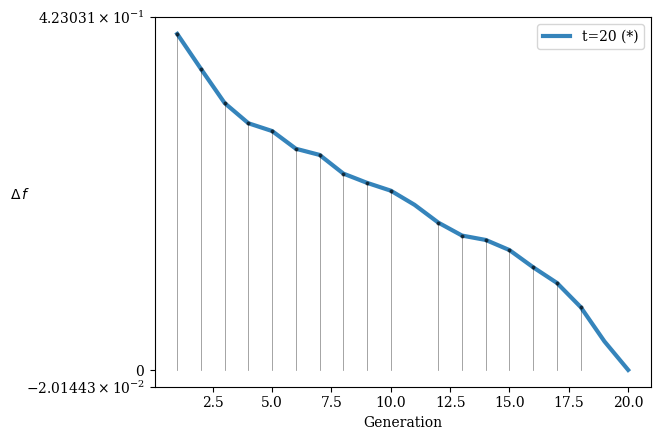

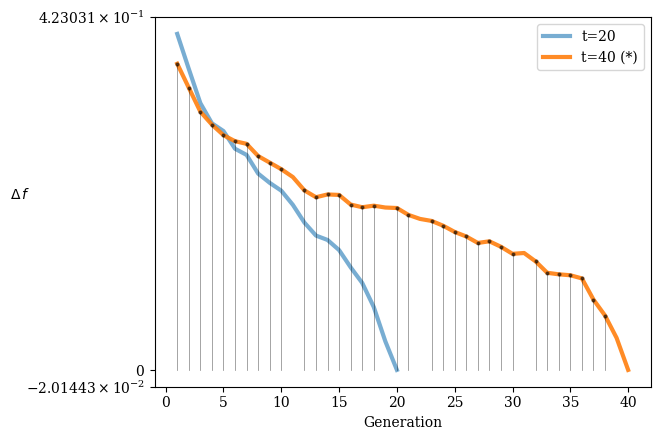

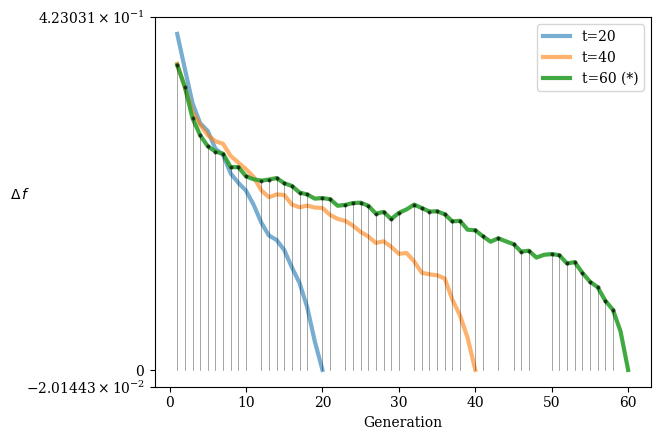

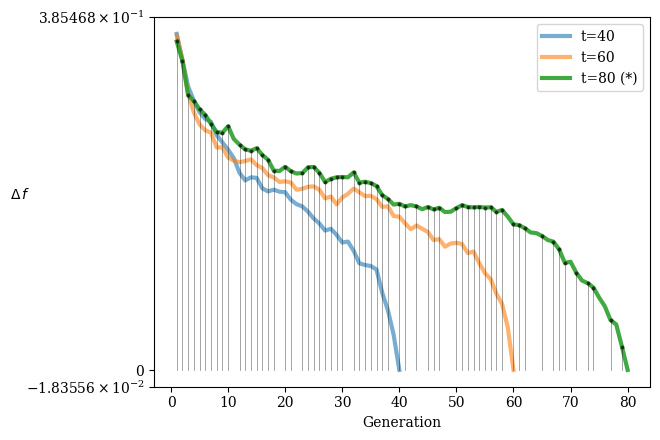

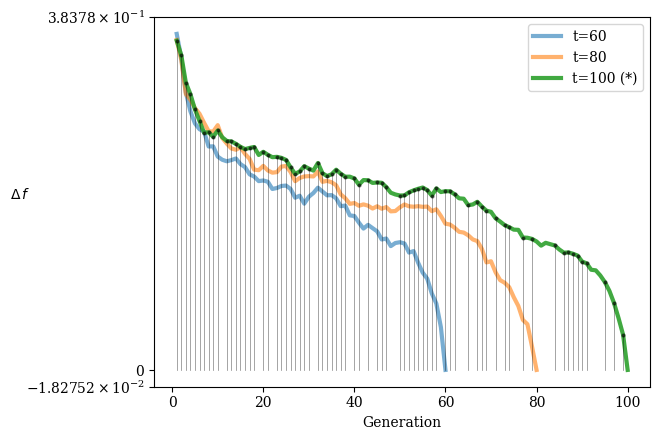

In [42]:
running = RunningMetricAnimation(delta_gen=20,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in res_5obj.history:
    running.update(algorithm)

<font size=4 color='#d39aed'>With more objectives, the search space becomes more complex, and it’s harder to find solutions that improve all objectives simultaneously. In higher-dimensional objective spaces, solutions rarely dominate others across all objectives; They might perform better in some but worse in others. As a result, many solutions become non-dominated together, as each one is better in a few objectives and worse in a few others.

<font size=4 color='#d39aed'>The difference between intervals increased, and there is more space between the curves as the number of objectives increased. Even around generation 100, the slopes of the curves are not close to flat and have become steeper.

<font size=4 color='#d39aed'>Unlike the two-objective case, where most solutions are dominated and only a few survive (resulting in faster progress), in many-objective problems, a large portion of the population remains in the non-dominated set, which is also a reason for slower convergence over generations. We can also observe that the curves remain far apart even at later generations, which shows that as the number of objectives increases, convergence becomes significantly slower.

<font size=4 color='#d39aed'>Based on the number of generations I ran, which did not result in convergence for cases with more than two objectives, starting from the 3-objective case onward, adding more objectives caused the algorithm to flip-flop between them. It can be speculated that it might not converge even with more generations.